## Processing Tournament Matchups 
By: Jackson Isidor and Alex Sullivan

In [45]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [46]:
raw_matchups = pd.read_csv("/Users/jacksonisidor/Documents/March Madness Project/MM Data Sets/Tournament Matchups.csv")

# 2024 bracket isn't even made but they are still in the data set so just remove them and drop columns we won't be using
## year/team pair will serve as index
raw_matchups = raw_matchups[raw_matchups["YEAR"] != 2024].drop(columns=["BY YEAR NO", "BY ROUND NO", "TEAM NO"])

raw_matchups.head()

,YEAR,TEAM,SEED,ROUND,CURRENT ROUND,SCORE
146,2023,Alabama,1,16,64,96.0
147,2023,Texas A&M Corpus Chris,16,64,64,75.0
148,2023,Maryland,8,32,64,67.0
149,2023,West Virginia,9,64,64,65.0
150,2023,San Diego St.,5,2,64,63.0


In [47]:
raw_matchups[raw_matchups["YEAR"] == 2021].TEAM.unique().size

63

2021 is missing a team, probably something COVID-related, so I will just drop that year from all our data.

In [48]:
raw_matchups = raw_matchups[raw_matchups['YEAR'] != 2021]

Merge with the team stats to have all the information in one place:

In [49]:
stats = pd.read_csv("/Users/jacksonisidor/Documents/March Madness Project/MM Data Sets/raw_stats.csv").drop(columns=["Unnamed: 0"])
raw_matchup_stats = pd.merge(raw_matchups, stats, on=["YEAR", "TEAM"], how="left").drop(columns=["SEED_y", "ROUND_y"])
raw_matchup_stats.rename(columns={"SEED_x":"SEED", "ROUND_x":"ROUND"}, inplace=True)

In [50]:
raw_matchup_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   YEAR           1764 non-null   int64  
 1   TEAM           1764 non-null   object 
 2   SEED           1764 non-null   int64  
 3   ROUND          1764 non-null   int64  
 4   CURRENT ROUND  1764 non-null   int64  
 5   SCORE          1764 non-null   float64
 6   WAB            1755 non-null   float64
 7   BADJ EM        1755 non-null   float64
 8   BARTHAG        1755 non-null   float64
 9   TALENT         1755 non-null   float64
 10  BADJ O         1755 non-null   float64
 11  BADJ D         1755 non-null   float64
 12  ELITE SOS      1755 non-null   float64
 13  WIN%           1755 non-null   float64
 14  PPPO           1755 non-null   float64
 15  K OFF          1755 non-null   float64
 16  AVG HGT        1755 non-null   float64
dtypes: float64(12), int64(4), object(1)
memory usage: 23

I am noticing a discrepancy in the merges so I will have to investigate why that is happening. We need every game for every round to make a useful predictor.

Check which teams are missing from each:

In [51]:
unique_teams_matchups = set(raw_matchups["TEAM"].unique())
unique_teams_stats = set(stats["TEAM"].unique())

# Teams present in raw_matchups but not in stats_data
teams_only_in_matchups = unique_teams_matchups - unique_teams_stats

# Teams present in stats_data but not in raw_matchups
teams_only_in_stats = unique_teams_stats - unique_teams_matchups

print("Teams only in matchups:", teams_only_in_matchups)
print("Teams only in stats:", teams_only_in_stats)

Teams only in matchups: {'Texas ', 'Virginia '}
Teams only in stats: {'Rutgers', 'North Florida', 'Alabama St.', 'Coppin St.', 'Bryant', 'Prairie View A&M', 'Lamar', 'Southeast Missouri St.', 'New Orleans'}


At least part of the problem seems to be trailing white space, so I will remove that.

In [52]:
# Assuming raw_matchups and stats_data are your DataFrames containing the matchups and stats data respectively
raw_matchups["TEAM"] = raw_matchups["TEAM"].str.strip()
stats["TEAM"] = stats["TEAM"].str.strip()

unique_teams_matchups = set(raw_matchups["TEAM"].unique())
unique_teams_stats = set(stats["TEAM"].unique())

# Teams present in raw_matchups but not in stats_data
teams_only_in_matchups = unique_teams_matchups - unique_teams_stats

# Teams present in stats_data but not in raw_matchups
teams_only_in_stats = unique_teams_stats - unique_teams_matchups

print("Teams only in matchups:", teams_only_in_matchups)
print("Teams only in stats:", teams_only_in_stats)

Teams only in matchups: set()
Teams only in stats: {'Rutgers', 'North Florida', 'Alabama St.', 'Coppin St.', 'Bryant', 'Prairie View A&M', 'Lamar', 'Southeast Missouri St.', 'New Orleans'}


That solved the problem for some of them. I think that maybe these teams in stats were in the play-in games (round of 68) and the matchups data set may only start at round of 64. I will check for that.

In [53]:
stats[stats['TEAM'].isin(teams_only_in_stats)]

,YEAR,TEAM,SEED,ROUND,WAB,BADJ EM,BARTHAG,TALENT,BADJ O,BADJ D,ELITE SOS,WIN%,PPPO,K OFF,AVG HGT
51,2023,Southeast Missouri St.,16,68,-11.6,-8.2,0.285,2.128,98.7,106.9,8.545,51.515152,1.028,102.6640,76.034
75,2022,Bryant,16,68,-4.8,-1.5,0.458,3.998,102.7,104.2,9.639,70.000000,1.051,105.2750,76.940
113,2022,Rutgers,11,68,-0.7,9.0,0.738,51.706,104.6,95.6,28.945,58.064520,1.025,102.6970,78.702
182,2019,Prairie View A&M,16,68,-6.9,-4.1,0.388,1.736,101.0,105.1,9.729,63.636360,1.031,103.1200,75.167
304,2017,New Orleans,16,68,-6.3,-1.9,0.446,0.455,99.1,101.0,11.906,60.714290,1.015,101.9040,75.938
445,2015,North Florida,16,68,-5.1,0.4,0.511,11.873,105.1,104.7,14.080,64.516130,1.094,109.6330,77.605
636,2012,Lamar,16,68,-4.3,4.3,0.619,0.870,104.2,99.9,15.047,65.625000,1.055,104.7930,75.746
681,2011,Alabama St.,16,68,-13.0,-15.5,0.139,0.200,90.1,105.6,8.673,46.875000,0.926,92.1392,76.060
814,2009,Alabama St.,16,68,-5.1,-3.0,0.416,0.201,99.6,102.6,10.210,68.965520,1.039,105.0130,77.353
890,2008,Coppin St.,16,68,-13.0,-15.4,0.140,4.120,90.2,105.6,16.141,41.176470,0.907,90.6896,76.401


As expected, all of these teams lost in the round of 68. For the sake of simplicity and working with the data we have, I will make this predictor only on the actual tournament games, excluding play-ins. 

Now, remerge the data with the corrections (removed white spaces and a left merge to drop R68 teams from stats):

In [54]:
raw_matchup_stats = pd.merge(raw_matchups, stats, on=["YEAR", "TEAM"], how="left").drop(columns=["SEED_y", "ROUND_y"])
raw_matchup_stats.rename(columns={"SEED_x":"SEED", "ROUND_x":"ROUND"}, inplace=True)

In [55]:
raw_matchup_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   YEAR           1764 non-null   int64  
 1   TEAM           1764 non-null   object 
 2   SEED           1764 non-null   int64  
 3   ROUND          1764 non-null   int64  
 4   CURRENT ROUND  1764 non-null   int64  
 5   SCORE          1764 non-null   float64
 6   WAB            1764 non-null   float64
 7   BADJ EM        1764 non-null   float64
 8   BARTHAG        1764 non-null   float64
 9   TALENT         1764 non-null   float64
 10  BADJ O         1764 non-null   float64
 11  BADJ D         1764 non-null   float64
 12  ELITE SOS      1764 non-null   float64
 13  WIN%           1764 non-null   float64
 14  PPPO           1764 non-null   float64
 15  K OFF          1764 non-null   float64
 16  AVG HGT        1764 non-null   float64
dtypes: float64(12), int64(4), object(1)
memory usage: 23

Looks good.

#### Data description from Kaggle: 

The matchups and final score of each team in the tournament. Each matchup is every two rows. For example, the first matchup in 2023 is Alabama vs. Texas A&M Corpus Chris with a final score of 96 - 75 with Alabama winning. The next matchup would be Maryland vs. West Virginia with a final score of 67 to 65 with Maryland winning.

Knowing how its made, I can put the matchups on 1 row instead of 2.

In [56]:
matchups = pd.DataFrame(columns=['year', 'team_1', 'seed_1', 'round_1', 'current_round', 'score_1',
                                 'team_2', 'seed_2', 'round_2', 'score_2'])

# iterate through data frame and jump 2 each iteration
for i in range(0, len(raw_matchup_stats), 2):
    team1_info = raw_matchup_stats.iloc[i]
    team2_info = raw_matchup_stats.iloc[i+1]
    
    matchup_info = {
        'year': team1_info['YEAR'],
        'team_1': team1_info['TEAM'],
        'seed_1': team1_info['SEED'],
        'round_1': team1_info['ROUND'],
        'score_1' : team1_info['SCORE'],
        'score_2' : team2_info['SCORE'],
        'current_round': team1_info['CURRENT ROUND'],
        'team_2': team2_info['TEAM'],
        'seed_2': team2_info['SEED'],
        'round_2': team2_info['ROUND'],
        'badj_em_1': team1_info['BADJ EM'],
        'badj_o_1': team1_info['BADJ D'],
        'badj_d_1': team1_info['BADJ O'],
        'wab_1': team1_info['WAB'],
        'barthag_1': team1_info['BARTHAG'],
        'talent_1': team1_info['TALENT'],
        'elite_sos_1': team1_info['ELITE SOS'],
        'win_percent_1': team1_info['WIN%'],
        'pppo_1': team1_info['PPPO'],
        'k_off_1': team1_info['K OFF'],
        'avg_hgt_1': team1_info["AVG HGT"],
        'badj_em_2': team2_info['BADJ EM'],
        'badj_o_2': team1_info['BADJ O'],
        'badj_d_2': team1_info['BADJ D'],
        'wab_2': team2_info['WAB'],
        'barthag_2': team2_info['BARTHAG'],
        'talent_2': team2_info['TALENT'],
        'elite_sos_2': team2_info['ELITE SOS'],
        'win_percent_2': team2_info['WIN%'],
        'pppo_2': team2_info['PPPO'],
        'k_off_2': team2_info['K OFF'],
        'avg_hgt_2': team2_info["AVG HGT"]
    }
    
    matchup_info_df = pd.DataFrame([matchup_info])
    matchups = pd.concat([matchups, matchup_info_df], ignore_index=True)

In [57]:
# get the winner of each game (1 = team 1 wins, 0 = team 2 wins)
matchups["winner"] = 1 * (matchups["score_1"] > matchups["score_2"])

# don't need score anymore because that is not something we are predicting... only winner
matchups.drop(columns=["score_1", "score_2"], inplace=True)

In [58]:
matchups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           882 non-null    object 
 1   team_1         882 non-null    object 
 2   seed_1         882 non-null    object 
 3   round_1        882 non-null    object 
 4   current_round  882 non-null    object 
 5   team_2         882 non-null    object 
 6   seed_2         882 non-null    object 
 7   round_2        882 non-null    object 
 8   badj_em_1      882 non-null    float64
 9   badj_o_1       882 non-null    float64
 10  badj_d_1       882 non-null    float64
 11  wab_1          882 non-null    float64
 12  barthag_1      882 non-null    float64
 13  talent_1       882 non-null    float64
 14  elite_sos_1    882 non-null    float64
 15  win_percent_1  882 non-null    float64
 16  pppo_1         882 non-null    float64
 17  k_off_1        882 non-null    float64
 18  avg_hgt_1 

In [59]:
matchups.head()

,year,team_1,seed_1,round_1,current_round,team_2,seed_2,round_2,badj_em_1,badj_o_1,...,badj_d_2,wab_2,barthag_2,talent_2,elite_sos_2,win_percent_2,pppo_2,k_off_2,avg_hgt_2,winner
0,2023,Alabama,1,16,64,Texas A&M Corpus Chris,16,64,27.1,88.3,...,88.3,-6.0,0.451,3.833,9.546,65.517241,1.098,109.864,75.074,1
1,2023,Maryland,8,32,64,West Virginia,9,64,16.5,95.0,...,95.0,1.5,0.895,40.731,35.542,57.575758,1.088,108.969,77.418,1
2,2023,San Diego St.,5,2,64,College of Charleston,12,64,21.2,90.1,...,90.1,1.7,0.782,0.200,8.862,90.909091,1.126,112.460,76.909,1
3,2023,Virginia,4,64,64,Furman,13,32,16.9,93.5,...,93.5,-2.0,0.697,4.159,10.319,77.419355,1.155,115.465,76.607,0
4,2023,Creighton,6,8,64,North Carolina St.,11,64,21.0,92.8,...,92.8,1.1,0.840,54.561,24.085,69.696970,1.115,111.298,77.043,1


Now the two teams are in one dataset with all of their stats. This is so many variables so I am going to get the difference between each corresponding variable. For example, (k off diff = k_off1 - koff2)

I will use only the differenced variables in the model, but I still have to keep the other the individual team stats for when I simulate the bracket and there are new matchups.

In [60]:
stat_variables = ['badj_em', 'badj_o', 'badj_d', 'wab', 'barthag', 'talent', 'elite_sos', 'win_percent', 'pppo', 
                  'k_off', 'avg_hgt']
for variable in stat_variables:
    matchups[f'{variable}_diff'] = matchups[f'{variable}_1'] - matchups[f'{variable}_2']

In [61]:
matchups.head()

,year,team_1,seed_1,round_1,current_round,team_2,seed_2,round_2,badj_em_1,badj_o_1,...,badj_o_diff,badj_d_diff,wab_diff,barthag_diff,talent_diff,elite_sos_diff,win_percent_diff,pppo_diff,k_off_diff,avg_hgt_diff
0,2023,Alabama,1,16,64,Texas A&M Corpus Chris,16,64,27.1,88.3,...,-27.1,27.1,16.2,0.505,62.286,24.154,19.776876,0.008,0.998,3.043
1,2023,Maryland,8,32,64,West Virginia,9,64,16.5,95.0,...,-16.5,16.5,-0.5,-0.032,3.690,-6.315,6.060606,-0.002,0.056,0.467
2,2023,San Diego St.,5,2,64,College of Charleston,12,64,21.2,90.1,...,-21.2,21.2,4.1,0.137,37.036,16.740,-9.659091,-0.062,-5.790,-0.205
3,2023,Virginia,4,64,64,Furman,13,32,16.9,93.5,...,-16.9,16.9,6.1,0.174,50.410,14.426,0.705645,-0.072,-7.131,-0.022
4,2023,Creighton,6,8,64,North Carolina St.,11,64,21.0,92.8,...,-21.0,21.0,0.8,0.073,12.798,8.184,-6.060606,-0.020,-1.706,0.827


#### Look at the distribution of winners:

In [62]:
matchups["winner"].value_counts()

winner
1    544
0    338
Name: count, dtype: int64

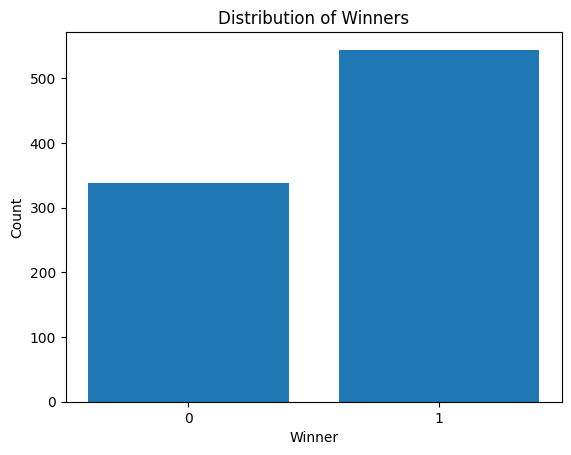

In [63]:
winner_counts = matchups["winner"].value_counts()
plt.bar(winner_counts.index, winner_counts.values)
plt.xlabel("Winner")
plt.ylabel("Count")
plt.title("Distribution of Winners")
plt.xticks(winner_counts.index, [1, 0])
plt.show()

The distribution seems to be fairly balanced.

#### Look at the distributions of each predictor by winner:

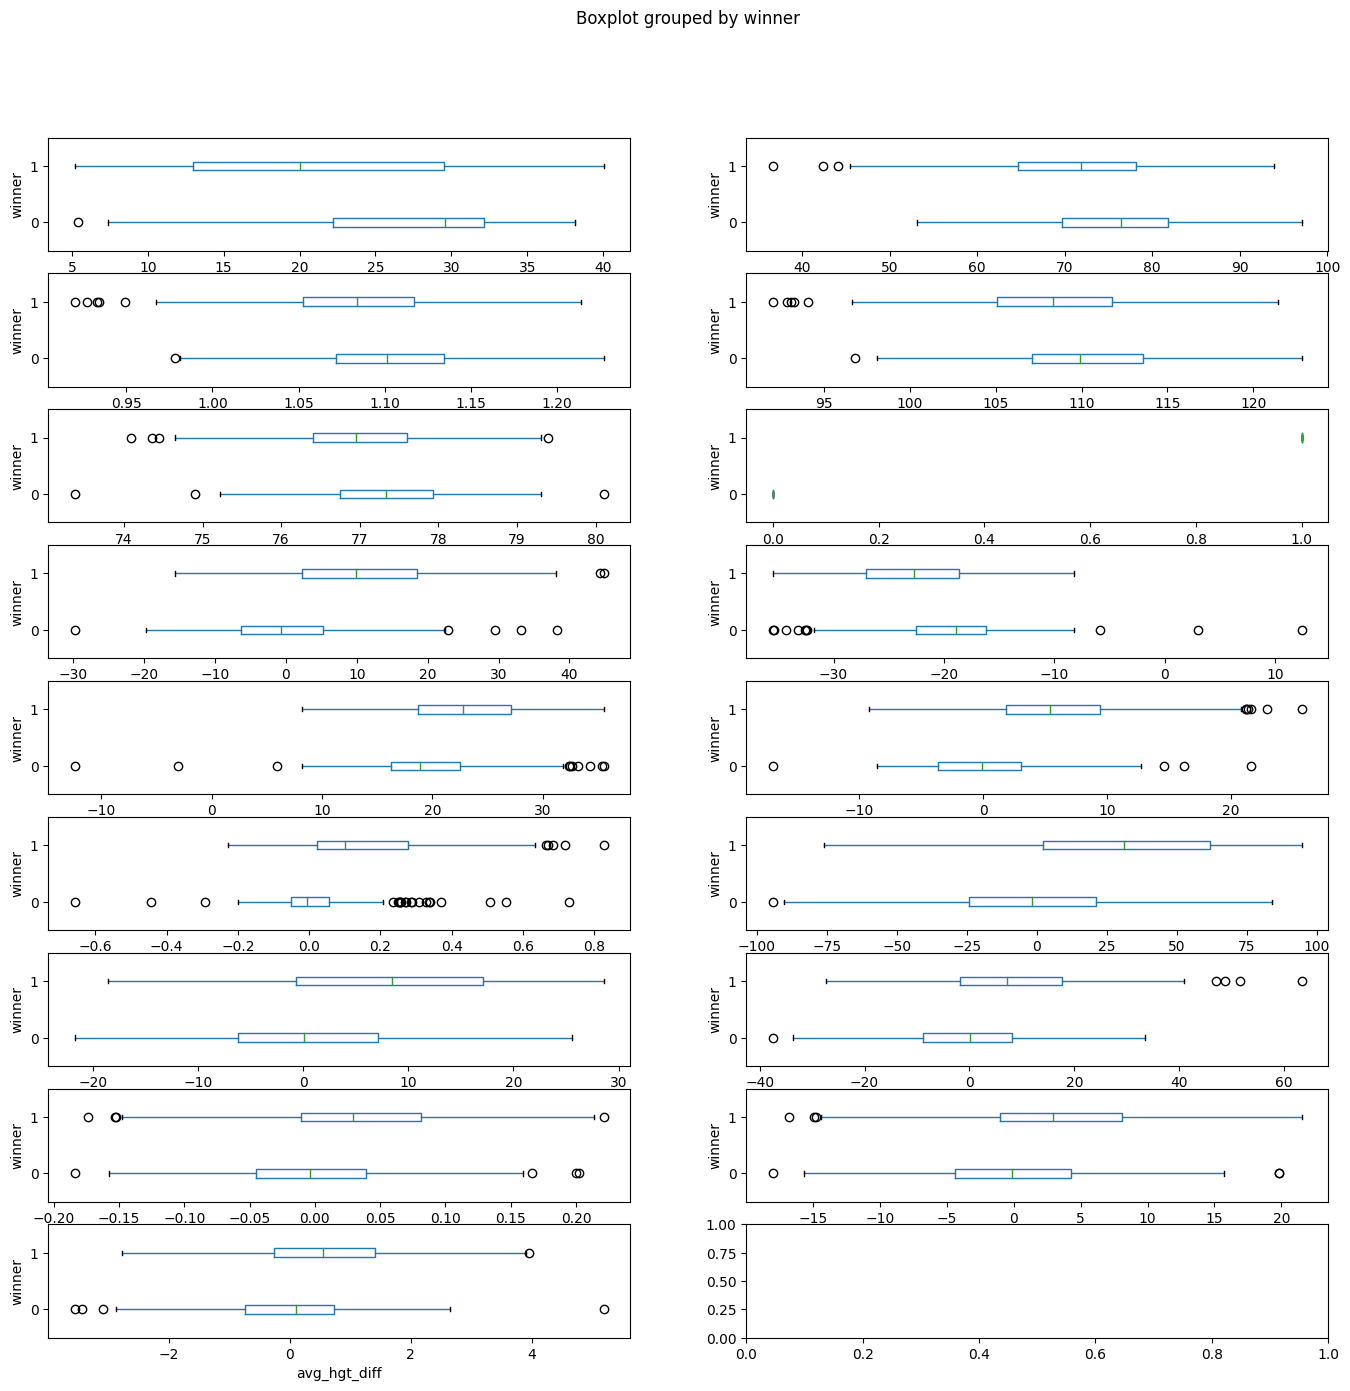

In [64]:
predictors = matchups.columns[25:]
target = "winner"

num_cols = 2
num_rows = len(predictors) // num_cols + (len(predictors) % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 16))

for i, predictor in enumerate(predictors):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    matchups.boxplot(column=predictor, by=target, grid=False, vert=False, ax=ax)
    ax.set_title('')
    ax.set_ylabel(target)
    ax.set_xlabel(predictor)

*Note:* Team 2 comes from the bottom of the bracket, which means they are generally a lower seed unless something happened in the round before (an upset from them or from Team 1) that changed this. Basically, in the first round, all Team 2's are a lower seed, but it could change after that. 

These plots show that, on average, team 2 wins more when the statistic is close to zero (generally representing an equal matchup). There is a wide range and tons of overlap on the boxplots, but March Madness is historically unpredictable, so this makes sense. We are just trying to do better than blind guessing. 

In [65]:
matchups.to_csv("matchups_stats.csv")

In [85]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

data = pd.read_csv("http://barttorvik.com/2024_team_results.csv")
data = data.shift(axis=1)
data.drop(columns=["rank"], inplace=True)
data

,team,conf,record,adjoe,oe Rank,adjde,de Rank,barthag,rank.1,proj. W,...,ConPF,ConPA,ConPoss,ConOE,ConDE,ConSOSRemain,Conf Win%,WAB,WAB Rk,"Fun Rk, adjt"
1,Connecticut,BE,35-3,127.161901,2,91.409838,4,0.978038,1,35.803257,...,1565.0,1288.0,1298.1500,1.205562,0.992181,0,0.900000,11.103968,1,88
2,Houston,B12,32-5,119.669658,15,86.499092,1,0.976636,2,32.000000,...,1313.0,1122.0,1167.2125,1.124902,0.961265,0,0.833333,10.029864,3,203
3,Purdue,B10,33-4,127.264938,1,95.131055,17,0.965996,3,33.843424,...,1657.0,1452.0,1364.3500,1.214498,1.064243,0,0.850000,10.706921,2,44
4,Auburn,SEC,27-8,121.127759,10,93.015440,7,0.954215,4,27.000000,...,1485.0,1258.0,1274.2250,1.165414,0.987267,0,0.722222,5.396581,9,317
5,Iowa St.,B12,29-8,113.612527,54,87.674395,2,0.951680,5,29.000000,...,1227.0,1156.0,1198.5750,1.023716,0.964479,0,0.722222,6.340322,6,185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,Stonehill,NEC,4-27,90.868792,355,114.500101,348,0.065477,358,4.000000,...,1014.0,1154.0,1087.8750,0.932092,1.060784,0,0.125000,-21.970356,355,341
359,IUPUI,Horz,6-26,92.727423,351,117.179065,358,0.063480,359,6.000000,...,1297.0,1634.0,1377.5875,0.941501,1.186132,0,0.100000,-21.545258,354,267
360,St. Francis PA,NEC,8-22,93.466451,347,118.143974,359,0.063301,360,8.000000,...,1033.0,1182.0,1063.8625,0.970990,1.111046,0,0.187500,-18.600930,340,138
361,Coppin St.,MEAC,2-27,85.348265,362,111.305508,298,0.045058,361,2.000000,...,866.0,1011.0,953.4375,0.908292,1.060374,0,0.071429,-22.998547,359,290


In [86]:
raw_matchups2024 = pd.read_csv("Tournament Matchups 2024.csv")
raw_matchups

FileNotFoundError: [Errno 2] No such file or directory: 'Tournament Matchups 2024.csv'